## Fraud Detection
1. We use RandomForestClassfier to predict transaction.

1. Data Preprocessing
    * Merge two data frame.
    * Handle missing data field.
    
1. Model's performance
    * Accuracy
    * Recall Score
    * Precision Score
    * F1 Score
 
1. Imbalanced Dataset
    * Under-sampling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

def print_model_performance(y_test, pred):
    matrix = confusion_matrix(y_test, pred)
    # separate out the confusion matrix components
    tpos = matrix[0][0]
    fneg = matrix[1][1]
    fpos = matrix[0][1]
    tneg = matrix[1][0]
    # calculate F!, Recall scores
    f1_s = round(f1_score(y_test, pred), 2)
    recall_s = round(recall_score(y_test, pred), 2)
    precision_s = round(precision_score(y_test, pred), 2)
    # calculate and display metrics
    print(matrix)
    print('Accuracy: '+ str(np.round(100*float(tpos+fneg)/float(tpos+fneg + fpos + tneg),2))+'%')
    print('Recall for Model : {}'.format(recall_s))
    print('Precision for Model : {}'.format(precision_s))
    print('F1 Score for Model : {}'.format(f1_s))


In [3]:
df_identity = import_data('train_identity.csv')
df_transaction = import_data('simple_train_transaction.csv')

Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%
Memory usage of dataframe is 60.12 MB
Memory usage after optimization is: 14.90 MB
Decreased by 75.2%


In [4]:
# Merge two data frame with TransactionID.
df_train = pd.merge(df_transaction, df_identity, on='TransactionID', how='left')
# Drop column with data type category.
df_train_merged = df_train.select_dtypes(exclude=['category'])

# Get columns contains NaN.
columns_contain_nan = df_train_merged.columns[df_train_merged.isna().any()]
# Check data type of it, because we will fill NaN with a specific value. We don't want set a value larger than data type.
print(np.unique(df_train_merged.loc[:, columns_contain_nan].dtypes))

# dtype float16 range between -32768 and 32767 or 0/65535, so we will fill in -9999 for NaN value.
df_train_merged.fillna(value=-9999, inplace=True)
df_train_is_fraud = df_train_merged['isFraud']
df_train_features = df_train_merged.drop(columns=['isFraud'])

# Split our data 80:20 for training and testing.
X_train, X_test, y_train, y_test = train_test_split(df_train_features, df_train_is_fraud, train_size=0.80, test_size=0.20, random_state=1)
print(len(X_train), len(X_test))

[dtype('float16') dtype('float32')]
15999 4000


/home/asu/Geek/SR_course/week3_assigment/venv/lib/python3.6/site-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [5]:
# Let's train our models!!
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

/home/asu/Geek/SR_course/week3_assigment/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [6]:
# Yaeee! our model's score is 0.979! Awesome!!
print('Model score value:{}.'.format(rfc.score(X_test, y_test)))
# But wait, is it true?
unique, counts = np.unique(y_train.values.tolist(), return_counts=True)
print(dict(zip(unique, counts)), 'Percentage of fraud:{}'.format(counts[1]/(counts[0] + counts[1])))
# Oops. the percentage of fraud is 0.02725, and our model's score is 0.979. Umm...
predict = rfc.predict(X_test)
pd.crosstab(y_test.values, predict, rownames=['Answer'], colnames=['predict'])


Model score value:0.9775.
{0: 15563, 1: 436} Percentage of fraud:0.027251703231451967


predict,0,1
Answer,,
0,3872,2
1,88,38


In [7]:
print_model_performance(y_test, predict)

[[3872    2]
 [  88   38]]
Accuracy: 97.75%
Recall for Model : 0.3
Precision for Model : 0.95
F1 Score for Model : 0.46


### Handle Imbalanced dataset
* Under-sampling (con: **discard useful information**)

In [8]:
# Looks like our model say most of them are not fraud. Maybe the train data are imbalanced.
df_train_is_fraud = df_train_merged.loc[df_train_merged['isFraud'] == 1]
df_train_not_fraud = df_train_merged.loc[df_train_merged['isFraud'] == 0]
print('Fraud count:{} Not Fraud count:{}'.format(len(df_train_is_fraud.index), len(df_train_not_fraud.index)))

# Under-sampling not fraud data.
df_train_not_fraud_reduced = df_train_not_fraud[:-5000]
print('Under sampling un fraud from {} to {}.'.format(len(df_train_not_fraud.index), len(df_train_not_fraud_reduced.index)))
df_under_sampling = pd.concat([df_train_is_fraud, df_train_not_fraud_reduced], ignore_index=True)

Fraud count:562 Not Fraud count:19437
Under sampling un fraud from 19437 to 14437.


In [9]:
y_train = df_under_sampling['isFraud']
X_train = df_under_sampling.drop(columns=['isFraud'])
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
predict = rfc.predict(X_test)
pd.crosstab(y_test.values, predict, rownames=['Answer'], colnames=['predict'])


/home/asu/Geek/SR_course/week3_assigment/venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predict,0,1
Answer,,
0,2914,960
1,12,114


In [10]:
print_model_performance(y_test, predict)

[[2914  960]
 [  12  114]]
Accuracy: 75.7%
Recall for Model : 0.9
Precision for Model : 0.11
F1 Score for Model : 0.19


### What's next
* We can try to find meaningful category data and translate it to our training dataset.
* Remove noise data.
* Handle imbalanced dataset with Over-sampling (con: **overfiting**)
    * SMOTE
    * ADASYN

ProductCD        category
card4            category
card6            category
P_emaildomain    category
R_emaildomain    category
M1               category
M2               category
M3               category
M4               category
M5               category
M6               category
M7               category
M8               category
M9               category
id_12            category
id_15            category
id_16            category
id_23            category
id_27            category
id_28            category
dtype: object


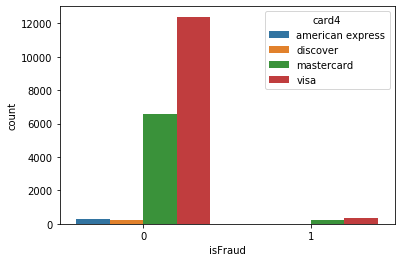

In [11]:
df_category = df_train.select_dtypes(include=['category'])
print(df_category.dtypes.head(20))
df_card4 = df_train.loc[:,['isFraud','card4']]
# print(product_codes.values)
sns.countplot(x="isFraud", data=df_card4, hue='card4')

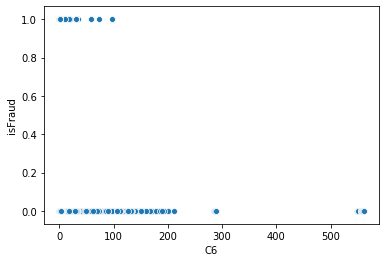

In [12]:
df_C6 = df_train.loc[:, ['isFraud', 'C6']]
sns.scatterplot(x='C6', y='isFraud', data=df_C6)